# Input Data Processing
This Jupyter notebook contains code to process automatic weather station (AWS) data to a standardized format for the PyGEM-EB model. The AWS dataset should be in a single comma/tab-separated file containing all timesteps and all data variables. If the data is not in that format, first use preprocess_AWS.ipynb. Note that this code may not be comprehensive for all errors that arise from the formatting of a specific dataset. 

In [27]:
import numpy as np
import os
import xarray as xr
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Set-up: Define variables
Fill out the cell below to set up the glacier being accessed and the filepaths.

In [28]:
# GLACIER INFORMATION   
glac_name = 'kaskawulsh'        # Glacier name for output file         
station_name = ''               # You choose: descriptive name for log and output (e.g. site name, year, etc.)
elev = 1800                     # Elevation of AWS [m a.s.l.]
lat = 60.7421656                # Latitude of AWS [decimal degrees]
lon = -139.2359388              # Longitude of AWS [decimal degrees]
station_type = 'on-ice'         # Type of station (on-ice, off-ice, or debris)

# FILEPATHS
data_fp = '../climate_data/AWS/'                            # Filepath to the folder of input data
data_fn = 'Raw/kaskawulsh/preprocessed.csv'                 # Filename of input data (relative to this notebook)
export_fp = '../climate_data/AWS/Processed/'                # Filepath to the folder to save this data
export_fn = export_fp + glac_name +'/'
if not os.path.exists(export_fn):
    os.mkdir(export_fn)                                     # Make folder for this glacier
export_fn += glac_name + station_name + '.csv'              # Name of output file
metadata_fn = export_fp + 'aws_metadata.txt'                # Name of metadata file
if not os.path.exists(metadata_fn):                
    with open(metadata_fn, 'w') as f:
        f.write('glacier\tstation\televation\tlatitude\tlongitude\ttype\n')         # Write metadata text file header

# TIMEZONE
timezone = 'GMT-07'             # Timezone of output data (should be local time)
input_timezone = 'GMT-00'       # Time zone of input data

# MINIMUM DATA PERCENTAGE
data_min_percentage = 0.8       # Below this threshold of data, AWS data will be thrown out

## 1. Load Data
From the output of the first cell, make sure the columns have been properly loaded. 

The cell below contains a dictionary with the possible for each variable. If the column names you want to use are missing, add those to the "names" dictionary.

Also specify the name of the time column and any NaN values specific to this dataset.

In [29]:
# Read in the data and make sure the columns were correctly loaded
# NOTE this step is likely to cause errors that can be fixed by adjusting the input arguments, for example delim_whitespace
rows_to_skip = 0     # Number of rows that contain text at the beginning of the file (34 for Storglaciaren), sep='\t'
df = pd.read_csv(data_fp + data_fn,skiprows=rows_to_skip,sep=',') 
print(df.columns.to_numpy())

['Unnamed: 0' 'Pressure' 'Temperature' 'RH' 'Wind' 'Gust' 'Winddir' 'SWin'
 'SWout' 'LWin' 'LWout']


In [30]:
# Fill out after executing above to check the variable names for time and precipitation
time_vn = 'Unnamed: 0' 
assert time_vn in df.columns, 'Fill out time variable name'

names = {'temp':['site_temp_USGS','temperature','Tair_aws','temp','TA_2.0m','T','AirTC_Avg','Temperature'],
            'tp':['Precip_Weighing_Incremental','precipitation','Ptotal_aws','tp','P'],
            'rh':['RelHum','RH','rh','rH','RH_aws','RH_2.0m'],
            'SWin':['RadiationIn','SWin','SWin_aws','SW_IN','SWUpper_Avg'],
            'SWout':['RadiationOut','SWout','SWout_aws','SW_out','SW_OUT','SWLower_Avg'],
            'LWin':['LWRadiationIn','LWin','LWin_aws','LW_in','LW_IN','Lwin'],
            'LWout':['LWRadiationOut','LWout','LWout_aws','LW_OUT'],
            'NetRad':['NetRad'],
            'wind':['WindSpeed','wind','Wind','ws_aws','WS','WS_ms_Avg'],
            'winddir':['VecAvgWindDir','WindDir','Winddir','winddir','WD'],
            'sp':['barom','sp','press','Press_aws','Barom','BV_BP_Avg','Pressure'],
            'tcc':['cloud_fraction','tcc','CCF','CCF_aws'],
            'dtemp':['dtemp','dewpoint_temp']}

nan_values = [-888.8800,-888.9,107.572,178.215,178.916]
for nan_value in nan_values:
    df = df.where(df != nan_value)

In [31]:
# ===== Space for extra preprocessing if opening the file isn't enough: =====
# n = len(df['TIMESTAMP'])
# store = []
# for i in range(n):
#     datetime = str(df.index[i]) +' '+ df['TIMESTAMP'][i]
#     store.append(datetime)
# df['TIMESTAMP'] = store

If the data is sub-hourly, resampling requires the variable name for precipitation to be explicitly stated in 'precip_vn' so it can be summed rather than averaged.

In [32]:
# ===== If precipitation data is cumulative =====
precip_vn = 'Precip'     # This line can be skipped if the data is already hourly or if there is no precip
# orig = df[precip_vn].to_numpy().copy()
# orig[1:] = np.diff(orig)
# print(orig)
# df[precip_vn] = orig

## 2. Launch logger
The logger stores information regarding the process and is saved alongside the final output .csv.

In [33]:
# Get base logger
base_logger = logging.getLogger()

# Create logger which is only updated if a line has not already been documented
class UniqueLogger:
    def __init__(self, logger):
        self.logger = logger
        self.logged_messages = set()
        self.logger.setLevel(logging.DEBUG)

    def info(self, msg):
        if msg not in self.logged_messages:
            self.logger.info(msg)
            self.logged_messages.add(msg)

# Check if log filepath already exists; if so, overwrite
export_logger_fn = export_fn.replace('csv','log')
if os.path.exists(export_logger_fn):
    os.remove(export_logger_fn)

# Add log filepath to logger and get unique logger
fhandler = logging.FileHandler(filename=export_logger_fn)
base_logger.addHandler(fhandler)
logger = UniqueLogger(base_logger)

# Initiate logger
today = str(pd.Timestamp.today()).replace('-','_')[0:10]
logger.info(f'Data for {glac_name} prepared on {today}')

## 3. Resample to hourly
Add the time index to the dataframe. If the original data has a sub-hourly frequency, resample by taking averages of each variable, with the exception of precipitation which is summed.

In [34]:
# Optional: add start and end time to clip the data
# Uncomment one of the following lines

force_dates = False
# force_dates = ['start date','end date']         # Fill with datetime strings

In [35]:
# Set time as the dataframe index and remove the time column
data_start = pd.to_datetime(df[time_vn].iloc[0])
data_end = pd.to_datetime(df[time_vn].to_numpy()[-1])
freq = pd.to_datetime(df[time_vn].iloc[1]) - data_start
df = df.set_index(pd.to_datetime(df[time_vn]))

# Adjust timezone of index if necessary
if timezone != input_timezone:
    time_diff = float(timezone[-3:]) - float(input_timezone[-3:])
    df = df.set_index(pd.to_datetime(df.index) + pd.Timedelta(hours=time_diff))

# Clip data to forced dates
if force_dates:
    data_start = pd.to_datetime(force_dates[0])
    data_end = pd.to_datetime(force_dates[1])
    df = df.loc[data_start:data_end]

# Log the time
logger.info(f'Data extends from {data_start} to {data_end} with frequency {freq.seconds / 60} min')
ntimesteps = np.shape(pd.date_range(data_start,data_end,freq='h'))[0]
df = df.drop(time_vn,axis=1).astype(float)

# Resample hourly
df_ = df
if freq.seconds / 3600 < 1:
    cols_noP = np.delete(df_.columns.to_numpy(),np.where(df_.columns.to_numpy()==precip_vn))
    df = df_[cols_noP].resample('h').mean()
    df['tp'] = df_[precip_vn].resample('h').sum()
    df = df.loc[data_start:data_end]

## 4. Rename variables
The following code should rename inconsistent naming to that used in PyGEM-EB. It will print any variable names that were passed from the original file but were not renamed. Check this list to make sure this list doesn't contain any data you need, as it will be removed in the next step.

! If this list contains a data variable you need, the printed name was not included in the list of possible options. Uncomment the block of code labeled 'UPDATE NAMES', add the corresponding variable names, and rerun the renaming block. (Or manually add these names to the 'names' variable above.)

In [36]:
# RENAMING
drop_vars = [] # Storage for variables to be removed

# List all variables
all_vars = ['temp','tp','rh','SWin','SWout',
            'LWin','LWout','wind','winddir',
            'sp','tcc','NetRad','dtemp']

# Loop through dataset variables and try to rename
for var in df.columns.to_numpy():
    renamed = False

    # Loop through each actual variable and check if the column exists
    for var_check in all_vars:
        if var in names[var_check]:
            # Match found made: rename variable
            df = df.rename(columns={var:var_check})

            # Remove this variable such that only one column can exist
            all_vars.remove(var_check)

            # Store that the variable was renamed
            renamed = True

    # Drop variables that were not renamed
    if not renamed:
        drop_vars.append(var)

# Print missing variables
if len(drop_vars) > 0:
    print('Variables were not renamed, including:')
    print(drop_vars)
    print('Read this list and make sure it only includes variables you want to drop')
else:
    drop_vars = [0]

# Drop the variables that weren't identified in "names"
df = df.drop(drop_vars,axis=1)

Variables were not renamed, including:
['Gust']
Read this list and make sure it only includes variables you want to drop


## 5. Interpolate data and inspect
First throw out any data variables that don't meet the minimum data requirement. Then fill minor data holes with interpolation. Then check the data count to look for big data gaps that weren't filled by interpolation. This likely indicates the sensor was down for a period or wasn't installed until some time into the date range. That variable will be thrown out too.

In [37]:
# Loop through data
for var in df.columns:
    # Check how many of the timestamps are not NaNs
    percent_there = df[var].count() / ntimesteps

    # Below minimum data percentage, delete the column
    if percent_there < data_min_percentage:
        missing_percent = (1-data_min_percentage) * 100
        logger.info(f'Variable {var} removed: missing over {missing_percent:.0f}% of the data')
        df = df.drop(columns=var)
    
# Interpolate to fill remaining gaps
df = df.interpolate('linear')

# Double check the gaps were filled (long gaps can be missed)
for var in df.columns:
    # Only check not-full variables with more than 0 data points
    if df[var].count() < ntimesteps and df[var].count() > 0:
        # Check how much data is still missing
        nmissing = ntimesteps - df[var].count()
        missing = df[var][df[var].isna()]

        if len(missing) > 0:
            # Print a warning
            start_missing = str(missing.index[0])[0:10]
            end_missing = str(missing.index[-1])[0:10]
            logger.info(f'Variable {var} removed: missing {nmissing} values between {start_missing} and {end_missing} after interpolation')

## 6. Check units
Check the units of each variable. The best way to do this is manually specify the units of the variables you're using from the input data. The table below contains the units each variable is supposed to be in for the model.

| Variable      | Units |
| ----------- | ----------- |
| Temperature      | C       |
| Humidity   | % (0-100)        |
| Wind Speed      | m/s       |
| Wind Direction   | $\circ$        |
| Precipitation      | m (w.e.)       |
| Surface Pressure   | Pa        |
| Incoming Shortwave      | J/m$^2$       |
| Incoming Longwave   | J/m$^2$        |
| Cloud cover      | 0-1 (decimal)       |

In [38]:
# ===== If the units are specified in a row of the original dataframe, print and inspect ======
# df_units = pd.read_csv(data_fp + data_fn,skiprows=rows_to_skip,delim_whitespace=False) 
# print(df_units.iloc[0])

In [39]:
# ACTUAL DATA UNITS (FILL THIS OUT FOR THE VARIABLES IN df)
temp_units = 'C'
tp_units = 'm'
sp_units = 'mbar'
rh_units = '%'
wind_units = 'km hr-1'
winddir_units = 'degrees'
SWin_units = 'W m-2'
SWout_units = 'W m-2'
LWin_units = 'W m-2'
LWout_units = 'W m-2'
tcc_units = 'decimal'

In [40]:
# Fill out units of input data
units_in = {'temp':temp_units,'rh':rh_units,'SWin':SWin_units,'SWout':SWout_units,'LWin':LWin_units,'LWout':LWout_units,
            'wind':wind_units,'winddir':winddir_units,'sp':sp_units,'tp':tp_units,'tcc':tcc_units}

# Units we should be in
units_out = {'temp':'C','dtemp':'K','tp':'m','rh':'%',
        'SWin':'J m-2','SWout':'J m-2','LWin':'J m-2','LWout':'J m-2',
        'tcc':'0-1','wind':'m s-1','winddir':'deg','sp':'Pa'}

# Check each variable for common unit differences
if 'temp' in df.columns:
    if units_in['temp'] == 'K':
        df['temp'] = df['temp'] - 273.15
        print('Adjusted temp K-->C')
        units_in['temp'] = 'C'
    elif units_in['temp'] == 'F':
        df['temp'] = (df['temp'] - 32)*5/9
        print('Adjusted temp F-->C')
        units_in['temp'] = 'C'
    
if 'rh' in df.columns:
    if units_in['rh'] == 'decimal':
        df['rh'] = df['rh'] * 100
        print('Adjusted RH decimal-->%')
        units_in['rh'] = '%'

if 'wind' in df.columns:
    if units_in['wind'] == 'km hr-1':
        df['wind'] = df['wind'] / 1000 * 3600
        print('Adjusted wind speed-->m s-1')
        units_in['wind'] = 'm s-1'
    
if 'winddir' in df.columns:
    if units_in['winddir'] == 'rad':
        df['winddir'] = df['winddir'] * 180/np.pi
        print('Adjusted winddir radians-->deg')
        units_in['winddir'] = 'deg'
    
if 'tcc' in df.columns:
    if units_in['tcc'] == '%':
        df['tcc'] = df['tcc'] / 100
        print('Adjusted tcc %-->0-1')
        units_in['tcc'] = '0-1'
    
if 'tp' in df.columns:
    if units_in['tp'] == 'm s-1':
        df['tp'] = df['tp'] *3600
        print('Adjusted tp m/s-->m')
        units_in['tp'] = 'm'
    elif units_in['tp'] == 'mm':
        df['tp'] = df['tp'] / 1000
        print('Adjusted tp mm-->m')
        units_in['tp'] = 'm'

for rad in ['SWin','SWout','LWin','LWout']:
    if rad in df.columns:
        if units_in[rad] == 'W m-2':
            df[rad] = df[rad] * 3600
            print(f'Adjusted {rad} W m-2-->J m-2')
            units_in[rad] = 'J m-2'

if 'sp' in df.columns:
    if units_in['sp'] == 'mmHg':
        df['sp'] = df['sp'] * 133.32
        print('Adjusted sp mmHg-->Pa')
        units_in['sp'] = 'Pa'
    elif units_in['sp'] == 'cmHg':
        df['sp'] = df['sp'] * 1333.2
        print('Adjusted sp cmHg-->Pa')
        units_in['sp'] = 'Pa'
    elif units_in['sp'] == 'kPa':
        df['sp'] = df['sp'] * 1000
        print('Adjusted sp kPa-->Pa')
        units_in['sp'] = 'Pa'
    elif units_in['sp'] in ['mbar','hPa']:
        df['sp'] = df['sp'] * 100
        units_sp = units_in['sp']
        print(f'Adjusted sp {units_sp}-->Pa')
        units_in['sp'] = 'Pa'

# Check SW fluxes make sense (SWout cannot exceed SWin)
if 'SWout' in df.columns:
    df['SWout'] = df['SWout'].mask(df['SWout'] - df['SWin'] > 0,None)

Adjusted SWin W m-2-->J m-2
Adjusted SWout W m-2-->J m-2
Adjusted LWin W m-2-->J m-2
Adjusted LWout W m-2-->J m-2
Adjusted sp mbar-->Pa


## 7. Reasonable value filters
Pass over each data variable and remove any unreasonable values by setting them to a prescribed limit. You can choose to 'remove' (any rows with any variables outside of their range are removed) or 'clip' (clips extreme values to their bound). If you want to perform a different operation on any variables, you can add 'method' to the var_bounds dictionary under that variable.

In [41]:
method_bounds = 'remove' # Choose between 'remove' (remove rows with any variable outside of its range) and 'clip' (clip values to their bounds)
var_bounds = {'temp':{'low':-60,'high':50},
                'dtemp':{'low':-60,'high':30},
                'tp':{'low':0,'high':0.15},
                'rh':{'low':0,'high':100},
                'SWin':{'low':0,'high':1400*3600,'method':'clip'},
                'SWout':{'low':0,'high':1400*3600},
                'LWin':{'low':0,'high':500*3600},
                'LWout':{'low':0,'high':500*3600},
                'tcc':{'low':0,'high':1},
                'wind':{'low':0,'high':70},
                'winddir':{'low':0,'high':360},
                'sp':{'low':75000,'high':110000}}

In [42]:
for var in var_bounds:
    if var in df.columns:
        count_first = df[var].count()

        # check if need a special method for this var
        if 'method' in var_bounds[var]:
            method = var_bounds[var]['method']
        else:
            method = method_bounds
        
        # remove or clip the data
        if method == 'remove':
            df[var] = df[var].where(df[var].between(var_bounds[var]['low'], var_bounds[var]['high']))
            n_removed =  count_first - df[var].count()
            print(f'Removed {n_removed} because of {var}')
        elif method == 'clip':
            df[var] = df[var].clip(var_bounds[var]['low'], var_bounds[var]['high'])

if method_bounds == 'remove':
    # Interpolate to fill new gaps introduced
    df = df.interpolate('linear')

Removed 0 because of temp
Removed 0 because of rh
Removed 518 because of SWout
Removed 0 because of LWin
Removed 105 because of LWout
Removed 0 because of winddir
Removed 0 because of sp


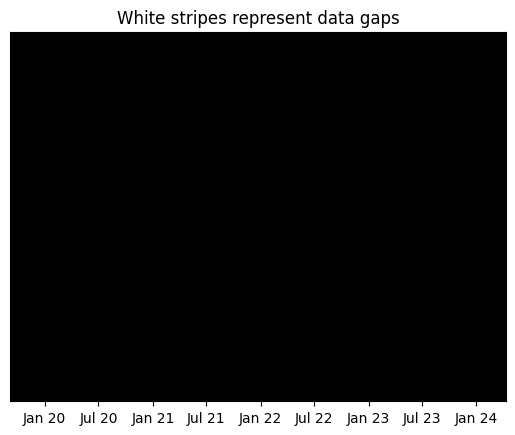

In [43]:
# Plot to look for any remaining gaps
if method_bounds == 'remove':
    fig, ax = plt.subplots()
    ax.bar(df.index, 1, pd.Timedelta(hours=1),color='k')
    ax.set_xlim(df.index[0], df.index[-1])
    ax.set_ylim(0,1)
    ax.set_yticks([])
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %y'))
    ax.set_title('White stripes represent data gaps')

## 8. Final check and export
Print the dataframe and plot the data and visually inspect. Look for any weird values and make sure the daily profiles seem about right (e.g., peak sunlight around noon). Finally export the data and metadata!

In [44]:
print(pd.concat([df.head(3), df.tail(3)]))

                          sp   temp    rh  winddir       SWin     SWout  \
Unnamed: 0                                                                
2019-09-05 13:00:00  81835.0  4.532  60.5  255.514  1895436.0  311724.0   
2019-09-05 14:00:00  81855.0  4.428  61.0  296.227  2159748.0  357444.0   
2019-09-05 15:00:00  81805.0  4.636  60.8  284.996  2248740.0  384768.0   
2024-04-09 19:00:00  80335.0 -8.331  25.5  358.000   332424.0  325800.0   
2024-04-09 20:00:00  80355.0 -8.331  25.5  358.000   151884.0  325800.0   
2024-04-09 21:00:00  80375.0 -8.331  25.5  358.000    47700.0  325800.0   

                         LWin      LWout  
Unnamed: 0                                
2019-09-05 13:00:00  852444.0  1476684.0  
2019-09-05 14:00:00  866124.0  1504836.0  
2019-09-05 15:00:00  874944.0  1526976.0  
2024-04-09 19:00:00  816156.0  1002384.0  
2024-04-09 20:00:00  826344.0   992736.0  
2024-04-09 21:00:00  871200.0   989820.0  


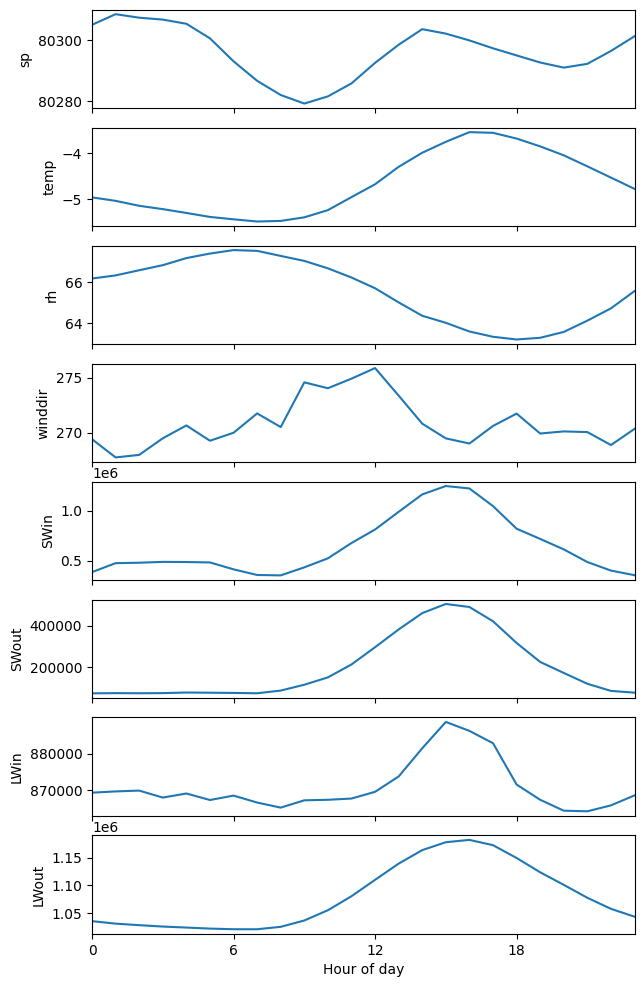

In [45]:
# check how many variables there are 
full_vars = []
for var in df.columns:
    if df[var].count() > 0:
        full_vars.append(var)

# make subplots
nvars = len(full_vars)
fig,axis = plt.subplots(nvars,1,figsize=(7,1.5*nvars),sharex=True)

# add hour of day column
df['hour'] = pd.to_datetime(df.index).hour

# loop through and plot variables
for i,var in enumerate(full_vars):
    var_hourly = []
    for hour in np.arange(24):
        # select the dataframe by the hour and find the mean
        ds_hour = df[df['hour'] == hour]
        hourly_mean = np.mean(ds_hour[var])
        var_hourly.append(hourly_mean)
    axis[i].plot(np.arange(24),var_hourly)
    axis[i].set_ylabel(var)
    axis[i].set_xlim((0,23))
axis[i].set_xlabel('Hour of day')
axis[i].set_xticks([0,6,12,18])
plt.show()

df = df.drop(columns=['hour'])

In [46]:
df = df.drop(columns='SWout')

In [47]:
# Store data
df.to_csv(export_fn)
print(f'Saved data to {export_fn}')

# Store metadata
new_line = f'{glac_name}\t{station_name}\t{elev}\t{lat}\t{lon}\t{station_type}'

# Read existing lines to check if this station is already written
with open(metadata_fn, 'r') as f:
    lines = f.readlines()
    existing_lines = set(line.strip() for line in lines[1:])

# Write new lines
if new_line not in existing_lines:
    with open(metadata_fn, 'a') as f:
        f.write(new_line)
    print(f'& metadata to {metadata_fn}')
else:
    print('& metadata is already written')

Saved data to ../climate_data/AWS/Processed/kaskawulsh/kaskawulsh.csv
& metadata is already written


In [180]:
# ===== DONE! =====